In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [3]:
data_downselect = pd.read_pickle('D:/PSED/Jarvis_cfid/data_downselect.pkl')

## Plot formation energy distribution

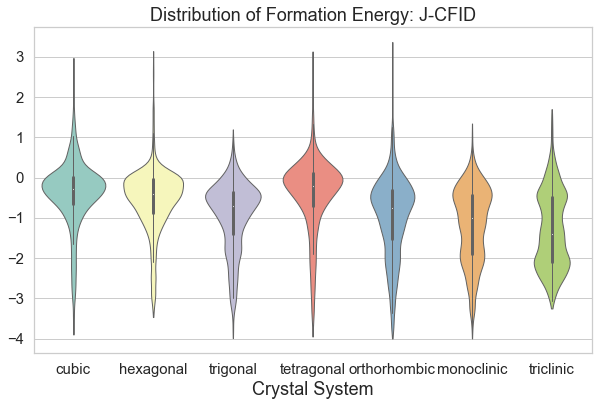

In [3]:
sns.set(font_scale=1.35, style='whitegrid')
fig, ax = plt.subplots(figsize=(10,6))
large_font = {'fontsize':18}
order = ['cubic', 'hexagonal', 'trigonal', 'tetragonal', 'orthorhombic', 'monoclinic', 'triclinic']
sns.violinplot(data=data_downselect, x='crys', y='formation_energy_peratom', palette='Set3', bw=.2, cut=1, linewidth=1, order=order)
# ax.set(ylim=(-.7,2))
plt.title('Distribution of Formation Energy: J-CFID', fontdict=large_font)
plt.xlabel('Crystal System', fontdict=large_font)
plt.ylabel('')
plt.savefig("D:/PSED/plots/E_jarvis.svg")
# plt.savefig("D:/PSED/plots/E_jarvis.png", dpi=200)

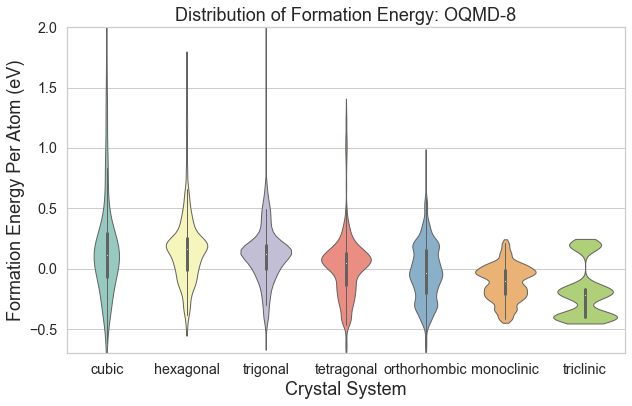

In [4]:
OQMD_data = pd.read_csv('D:/PSED/OQMD_xtalsys.csv')
sns.set(font_scale=1.3, style='whitegrid')
fig, ax = plt.subplots(figsize=(10,6))
order = ['cubic', 'hexagonal', 'trigonal', 'tetragonal', 'orthorhombic', 'monoclinic', 'triclinic']
sns.violinplot(data=OQMD_data, x='crystal_system', y='energy', palette='Set3', bw=.2, cut=1, linewidth=1, order=order)
ax.set(ylim=(-.7,2))
plt.title('Distribution of Formation Energy: OQMD-8', fontdict=large_font)
plt.ylabel('Formation Energy Per Atom (eV)', fontdict=large_font)
plt.xlabel('Crystal System', fontdict=large_font)
plt.savefig("D:/PSED/plots/E_OQMD_8els.svg")
# plt.savefig("D:/PSED/plots/E_OQMD_8els.png", dpi=200)

## Plot information entropy

In [1]:
from scipy.stats import differential_entropy
differential_entropy(data_downselect['formation_energy_peratom'])

entropies = pd.DataFrame(columns=['OQMD-8', 'J-CFID', 'crys'])
entropies['crys'] = ['cubic', 'hexagonal', 'trigonal', 'tetragonal', 'orthorhombic', 'monoclinic', 'triclinic']

for id, row in entropies.iterrows():
    row['OQMD-8'] = differential_entropy(OQMD_data[OQMD_data['crystal_system']==row['crys']]['energy'])
    row['J-CFID'] = differential_entropy(data_downselect[data_downselect['crys']==row['crys']]['formation_energy_peratom'])


NameError: name 'data_downselect' is not defined

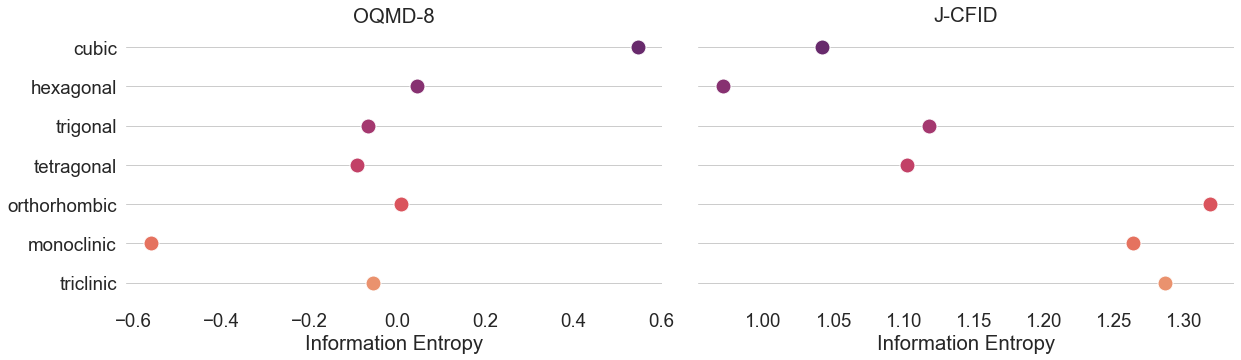

In [12]:
sns.set_theme(style='whitegrid', font_scale=1.7)


g = sns.PairGrid(entropies, x_vars=entropies.columns[:-1], y_vars=["crys"],
                 height=5, aspect=1.7)

# Draw a dot plot using the stripplot function
g.map(sns.stripplot, size=15, orient="h", jitter=False,
      palette="flare_r", linewidth=1, edgecolor="w")

g.set(xlabel="Information Entropy", ylabel="")

# Use semantically meaningful titles for the columns
titles = ['OQMD-8', 'J-CFID']

for ax, title in zip(g.axes.flat, titles):

    # Set a different title for each axes
    ax.set(title=title)

    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)
plt.savefig("D:/PSED/plots/info_entropy_grid.svg", bbox_inches='tight')
# plt.savefig("D:/PSED/plots/info_entropy_grid.png", dpi=200, bbox_inches='tight')

## Post-process results

In [4]:
results_path = 'D:/PSED/Results/Jarvis_term_1000_cleaned/'
entropies = pd.read_pickle(results_path + 'info_entropy_evolution.pkl')
entropies

,cubic,orthorhombic,trigonal,hexagonal,tetragonal,monoclinic,triclinic
0,1.163909,0.329138,0.927769,0.976069,0.719418,1.264707,1.329689
1,1.163909,0.711689,0.927769,0.976069,0.719418,1.264707,1.329689
2,1.163909,0.675517,0.927769,0.976069,0.719418,1.264707,1.329689
3,1.163909,0.734083,0.927769,0.976069,0.719418,1.264707,1.329689
4,1.163909,0.734083,0.927769,0.976069,0.889702,1.264707,1.329689
...,...,...,...,...,...,...,...
950,1.580706,1.616853,1.433008,1.427548,1.594200,1.438892,1.395791
951,1.580706,1.616853,1.433008,1.427548,1.593301,1.438892,1.395791
952,1.580706,1.616853,1.433008,1.427548,1.592847,1.438892,1.395791
953,1.580706,1.616853,1.433008,1.427548,1.592368,1.438892,1.395791


cubic
orthorhombic
trigonal
hexagonal
tetragonal
monoclinic
triclinic


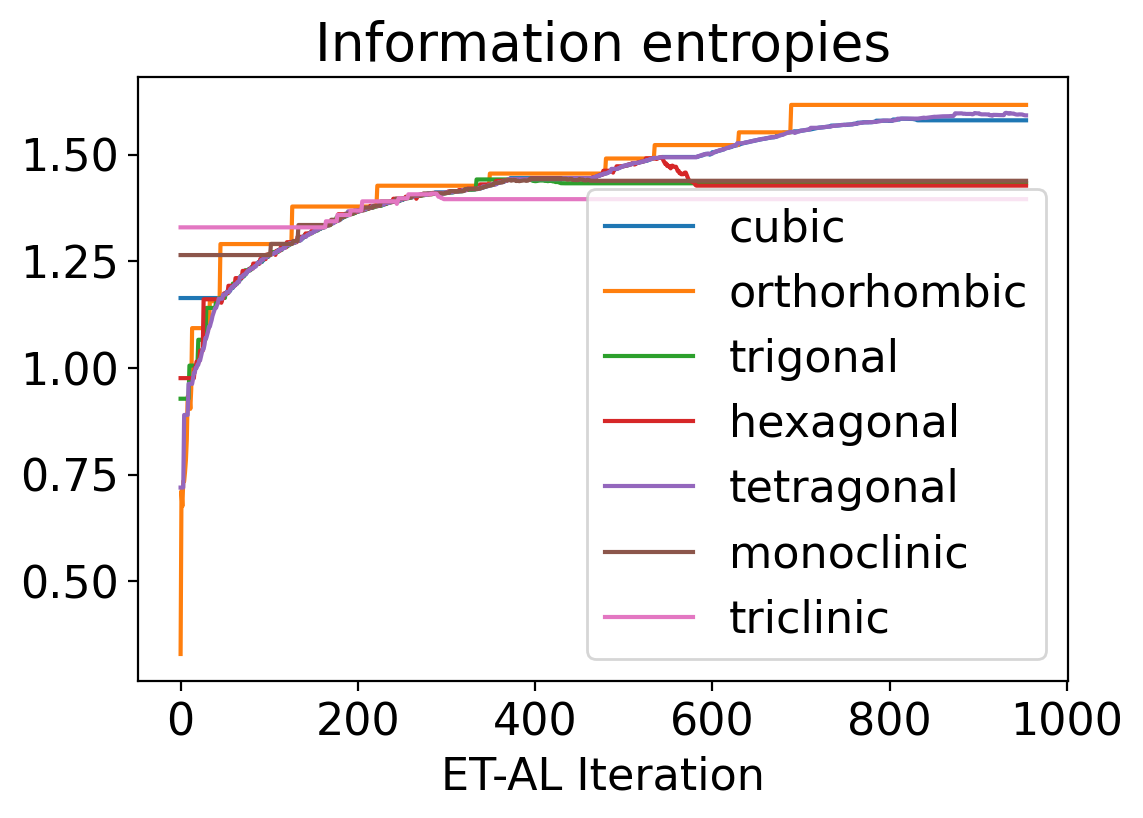

In [7]:
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(dpi=200)
for col in entropies:
    ax.plot(entropies[col], label=col)
    print(col)
ax.legend(loc=4)
plt.title('Information entropies')
plt.xlabel('ET-AL Iteration')
plt.savefig(results_path + 'info_entropy_evolution.svg', bbox_inches='tight')
# plt.savefig(results_path + 'info_entropy_evolution.png', dpi=200, bbox_inches='tight')

In [12]:
data_l = pd.read_pickle(results_path + 'data_l.pkl')
data_test = pd.read_pickle(results_path + 'data_test.pkl')
sample_path = np.load(results_path + 'sample_path.npy').astype(int)
samples = sample_path[sample_path != 0]
data_u = data_downselect.drop(index=data_l.index.union(data_test.index), inplace=False)
# data_l_etal = 

In [13]:
samples_etal = data_downselect.loc[samples]
samples_rand = data_u.sample(n=samples.shape[0], random_state=42)

data_l_etal = pd.concat([data_l, samples_etal])
data_l_rand = pd.concat([data_l, samples_rand])

In [14]:
data_l_rand.shape

(1954, 64)

## tSNE plots
tSNE mapping `cgcnn` features to 2D, then split -> train and test.

In [15]:
cgcnn_features_all = pd.read_pickle('D:/PSED/Jarvis_cfid/cgcnn_features_sorted.pkl').feature
cgcnn_features = cgcnn_features_all.loc[data_downselect.index]
cgcnn_features_test = pd.Series([np.asarray(row) for row in cgcnn_features], index=data_downselect.index)
features = np.stack(cgcnn_features.values)

In [16]:
features.shape

(10898, 32)

In [7]:
from sklearn.manifold import TSNE
cgcnn_tsne = TSNE(n_components=2, learning_rate='auto', perplexity=50, init='pca').fit_transform(features)
cgcnn_tsne = pd.DataFrame(cgcnn_tsne, columns=['tsne1', 'tsne2'], index=data_downselect.index)
cgcnn_tsne['crys'] = data_downselect['crys']
'''
cgcnn_tsne['dataset'] = pd.NaT
for idx, row in cgcnn_tsne.iterrows():
    if idx in data_test.index:
        cgcnn_tsne.at[idx, 'dataset'] = 'test'
    elif idx in data_l.index:
        cgcnn_tsne.at[idx, 'dataset'] = 'labeled'
    else:
        cgcnn_tsne.at[idx, 'dataset'] = 'unlabeled'
'''

c:\Users\hzz6536\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


"\ncgcnn_tsne['dataset'] = pd.NaT\nfor idx, row in cgcnn_tsne.iterrows():\n    if idx in data_test.index:\n        cgcnn_tsne.at[idx, 'dataset'] = 'test'\n    elif idx in data_l.index:\n        cgcnn_tsne.at[idx, 'dataset'] = 'labeled'\n    else:\n        cgcnn_tsne.at[idx, 'dataset'] = 'unlabeled'\n"

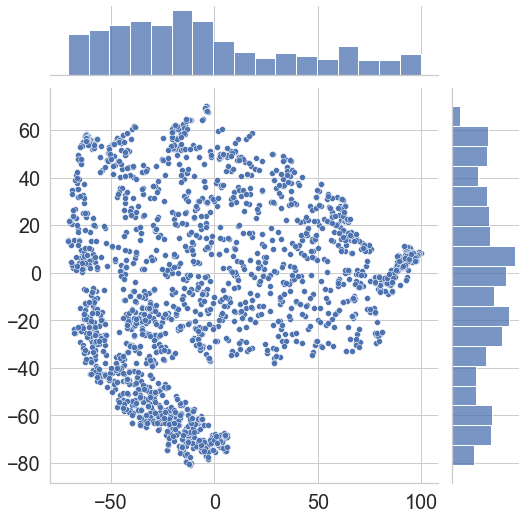

In [17]:
import matplotlib as mpl
new_rc_params = {'text.usetex': False,
"svg.fonttype": 'none'
}
mpl.rcParams.update(new_rc_params)
sns.set_theme(style='whitegrid', font_scale=1.8)
h = sns.jointplot(data=cgcnn_tsne.loc[data_l_etal.index], x='tsne1', y='tsne2', height=8)
h.set_axis_labels()
plt.savefig('D:/PSED/plots/tsne_labeled.svg')

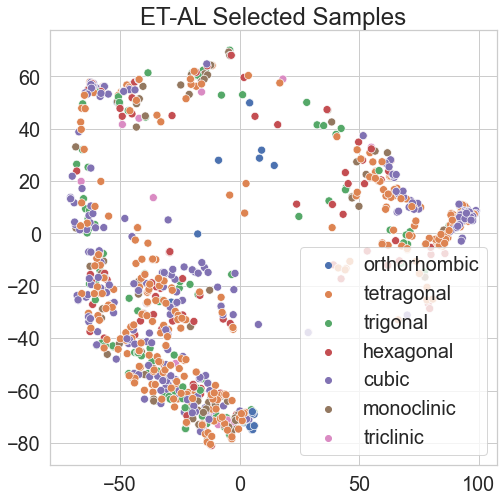

In [34]:
sns.set_theme(style='whitegrid', font_scale=1.8)
f, ax = plt.subplots(figsize=(8, 8))
hue_order = ['orthorhombic', 'tetragonal', 'trigonal', 'hexagonal', 'cubic', 'monoclinic', 'triclinic']
# hue_order = ['cubic', 'hexagonal', 'trigonal', 'tetragonal', 'orthorhombic', 'monoclinic', 'triclinic']
h = sns.scatterplot(data=cgcnn_tsne.loc[samples_etal.index], x='tsne1', y='tsne2', hue='crys', hue_order=hue_order, s=64)
h.set(xlabel=None, ylabel=None)
legend = h.legend()
plt.title('ET-AL Selected Samples', fontdict={'size':24})
plt.savefig('D:/PSED/plots/tsne_etal.svg')

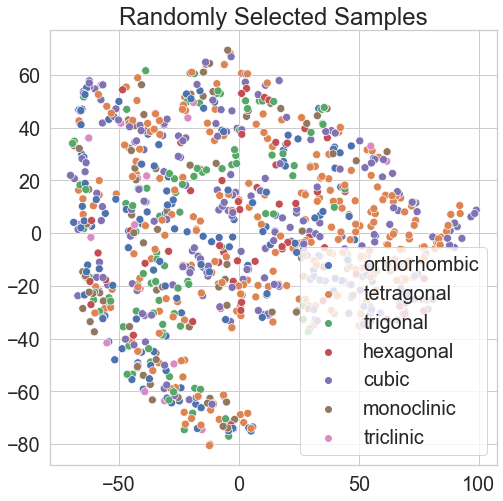

In [35]:
sns.set_theme(style='whitegrid', font_scale=1.8)
f, ax = plt.subplots(figsize=(8, 8))
h = sns.scatterplot(data=cgcnn_tsne.loc[samples_rand.index], x='tsne1', y='tsne2', hue='crys', hue_order=hue_order, s=64)
h.set(xlabel=None, ylabel=None)
legend = h.legend()
plt.title('Randomly Selected Samples', fontdict={'size':24})
plt.savefig('D:/PSED/plots/tsne_rand.svg')

In [38]:
results_path = 'D:/PSED/Results/Jarvis_term_1000_cleaned/'
data_downselect = pd.read_pickle('D:/PSED/Jarvis_cfid/data_downselect.pkl')
# cgcnn_features_all = pd.read_pickle('D:/PSED/Jarvis_cfid/cgcnn_features_sorted.pkl').feature
descriptors_all = pd.read_pickle('D:/PSED/Jarvis_features.pkl').drop(columns=['Compound'])
descriptors = descriptors_all.drop(columns=descriptors_all.columns[np.where(descriptors_all.var() == 0)])
data_l = pd.read_pickle(results_path + 'data_l.pkl')
data_test = pd.read_pickle(results_path + 'data_test.pkl')
sample_path = np.load(results_path + 'sample_path.npy').astype(int)
samples = sample_path[sample_path != 0]
data_u = data_downselect.drop(index=data_l.index.union(data_test.index), inplace=False)

samples_etal = data_downselect.loc[samples]
samples_rand = data_u.sample(n=samples.shape[0], random_state=42)


tSNE plots for descriptors

In [121]:
from sklearn.manifold import TSNE
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

dim_red = make_pipeline(StandardScaler(), TSNE(n_components=2, learning_rate='auto', perplexity=50, init='pca'))
descriptors_tsne = dim_red.fit_transform(descriptors)


c:\Users\hzz6536\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


In [122]:
descriptors_tsne = pd.DataFrame(descriptors_tsne, index=data_downselect.index)

etal_tsne = descriptors_tsne.loc[samples_etal.index]
rand_tsne = descriptors_tsne.loc[samples_rand.index]
labeled_tsne = descriptors_tsne.loc[data_l.index]


In [123]:
etal_tsne.values

array([[-42.164837,  29.984629],
       [-55.20463 ,  69.490234],
       [ 54.51276 , -59.941746],
       ...,
       [-22.183487,  38.80698 ],
       [-70.513916, -33.710403],
       [-36.44055 , -16.915173]], dtype=float32)

c:\Users\hzz6536\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


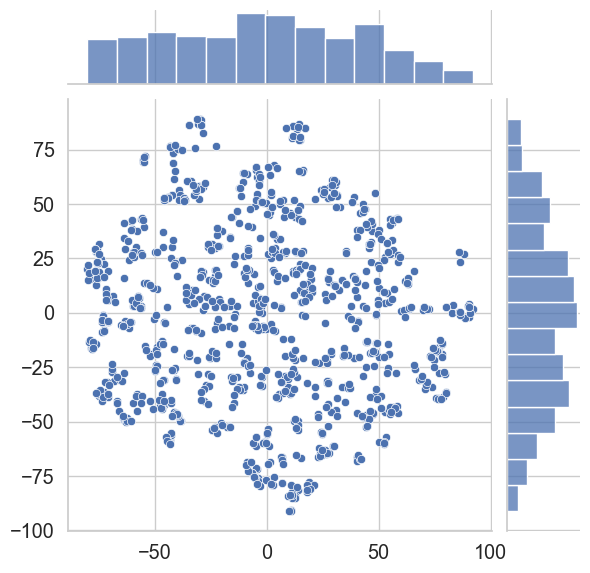

In [124]:
sns.set_theme(style='whitegrid', font_scale=1.3)
# f, ax = plt.subplots(figsize=(6.5, 6.5))
sns.jointplot(labeled_tsne.values[:,0], labeled_tsne.values[:,1])
# plt.title('tSNE Plot of Graph Embeddings')

c:\Users\hzz6536\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'ET-AL Selected Samples')

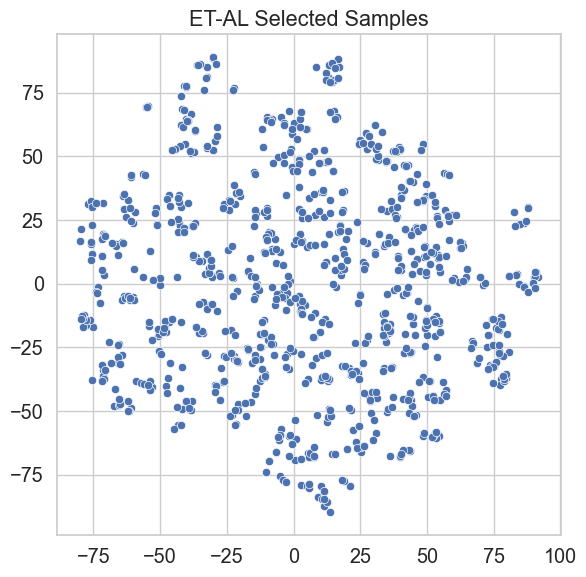

In [128]:
sns.set_theme(style='whitegrid', font_scale=1.3)
f, ax = plt.subplots(figsize=(6.5, 6.5))
sns.scatterplot(etal_tsne.values[:,0], etal_tsne.values[:,1])
plt.title('ET-AL Selected Samples')

c:\Users\hzz6536\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Randomly Selected Samples')

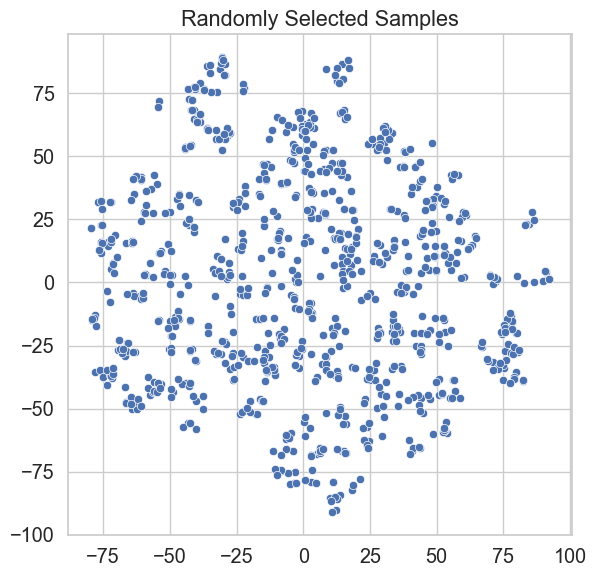

In [127]:
sns.set_theme(style='whitegrid', font_scale=1.3)
f, ax = plt.subplots(figsize=(6.5, 6.5))
sns.scatterplot(rand_tsne.values[:,0], rand_tsne.values[:,1])
plt.title('Randomly Selected Samples')

In [42]:
from sklearn.metrics import pairwise_distances
def gaussian_kernel(X, Y, sigma=1.0):
    beta = 1. / (2. * sigma**2)
    dist = pairwise_distances(X, Y)
    s = beta * dist.flatten()
    return np.exp(-s)

def maximum_mean_discrepancy(X_gen, X_test):
    
    # X_gen = gen_func(2000)
    X_gen = X_gen.reshape((X_gen.shape[0], -1))
    X_test = X_test.reshape((X_test.shape[0], -1))
      
    mmd = np.mean(gaussian_kernel(X_gen, X_gen)) - \
            2 * np.mean(gaussian_kernel(X_gen, X_test)) + \
            np.mean(gaussian_kernel(X_test, X_test))
    
    return mmd

In [39]:
descriptors

,MagpieData minimum Number,MagpieData maximum Number,MagpieData range Number,MagpieData mean Number,MagpieData avg_dev Number,MagpieData mode Number,MagpieData minimum MendeleevNumber,MagpieData maximum MendeleevNumber,MagpieData range MendeleevNumber,MagpieData mean MendeleevNumber,...,MagpieData avg_dev GSmagmom,MagpieData mode GSmagmom,MagpieData minimum SpaceGroupNumber,MagpieData maximum SpaceGroupNumber,MagpieData range SpaceGroupNumber,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber,ewald_energy_per_atom,volume_per_site
10004,4.0,24.0,20.0,16.75,7.250,24.0,49.0,83.0,34.0,62.000,...,0.000000,0.0,2.0,229.0,227.0,163.500,80.75000,229.0,0.000000,10.628487
10009,16.0,56.0,40.0,36.00,20.000,16.0,9.0,88.0,79.0,48.500,...,0.000000,0.0,70.0,229.0,159.0,149.500,79.50000,70.0,-15.676060,33.092291
10011,28.0,56.0,28.0,35.60,8.160,28.0,9.0,84.0,75.0,59.800,...,0.285789,0.0,166.0,229.0,63.0,202.200,28.96000,166.0,-27.638016,20.330452
10018,23.0,45.0,22.0,26.25,4.875,23.0,46.0,59.0,13.0,49.125,...,0.338728,0.0,194.0,229.0,35.0,224.125,7.53125,229.0,0.000000,13.044840
10020,4.0,38.0,34.0,18.50,14.500,4.0,8.0,67.0,59.0,50.750,...,0.223273,0.0,194.0,225.0,31.0,209.500,15.50000,194.0,0.000000,15.094069
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9970,4.0,32.0,28.0,15.50,11.500,4.0,43.0,79.0,36.0,64.000,...,0.000008,0.0,194.0,225.0,31.0,201.750,11.62500,194.0,0.000000,12.003172
9981,14.0,77.0,63.0,31.60,21.120,14.0,12.0,78.0,66.0,61.200,...,0.000000,0.0,194.0,227.0,33.0,220.000,10.40000,227.0,0.000000,17.506716
9983,4.0,46.0,42.0,28.40,14.080,23.0,46.0,67.0,21.0,56.600,...,0.000000,0.0,194.0,229.0,35.0,220.400,10.56000,225.0,0.000000,14.266754
9989,8.0,56.0,48.0,22.00,17.000,8.0,9.0,88.0,79.0,67.750,...,0.000000,0.0,12.0,229.0,217.0,80.750,74.12500,12.0,-20.698354,16.961881


In [54]:
cgcnn_features.loc[data_l_etal.index]

50       [0.6956512928009033, 0.0072820489294826984, 0....
80       [0.7088689208030701, 0.027511736378073692, 0.7...
85       [0.041310202330350876, 0.139915332198143, 0.09...
131      [0.4029618501663208, 0.0082946652546525, 0.124...
284      [0.7385602593421936, 0.03993276134133339, 0.16...
                               ...                        
10075    [1.1821293830871582, 0.043302327394485474, 0.2...
55490    [0.08590959012508392, 0.023120418190956116, 0....
54681    [0.16820617020130157, 0.1434164047241211, 0.30...
6947     [1.410791277885437, 0.003595364047214389, 0.33...
40606    [0.1989775002002716, 0.03709908574819565, 2.75...
Name: feature, Length: 1954, dtype: object

In [56]:
cgcnn_tsne

,tsne1,tsne2,crys
4,-17.619421,25.764284,trigonal
6,33.926727,-19.591049,cubic
24,22.669834,33.583366,cubic
25,6.389981,6.714555,cubic
26,-10.436357,-4.548157,orthorhombic
...,...,...,...
55662,8.924199,-30.694489,cubic
55669,69.411224,-26.598366,cubic
55673,97.444633,4.934184,cubic
55677,63.220604,-18.580156,cubic


In [58]:
maximum_mean_discrepancy(cgcnn_tsne.loc[data_l_etal.index, ['tsne1', 'tsne2']].values, cgcnn_tsne.loc[data_test.index, ['tsne1', 'tsne2']].values)

0.0014956363011151552

In [59]:
maximum_mean_discrepancy(cgcnn_tsne.loc[data_l_rand.index, ['tsne1', 'tsne2']].values, cgcnn_tsne.loc[data_test.index, ['tsne1', 'tsne2']].values)

0.0007042998913675547

In [52]:
maximum_mean_discrepancy(np.stack(cgcnn_features.loc[data_l_rand.index].values), np.stack(cgcnn_features.loc[data_test.index].values))

0.0005038078987842365

In [49]:
maximum_mean_discrepancy(descriptors.loc[data_l_rand.index].values, descriptors.loc[data_test.index].values)

0.0007120938276517491